In [1]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import logging
from numpy import random
import gensim
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [10]:
df = pd.read_excel('wsd_data.xlsx')
df = df[pd.notnull(df['CATEGORY'])]
print(df.head(3))
print(df['SENTENCE'].apply(lambda x: len(x.split(' '))).sum())

                                            SENTENCE CATEGORY
0  Tidak menghalang Kaka untuk meneruskan karier ...  manisan
1  Pelakon Sasqia Dahuri yang sah menjadi isteri ...  manisan
2  Sebagai kafe yang mengutamakan status halal, k...  manisan
4729


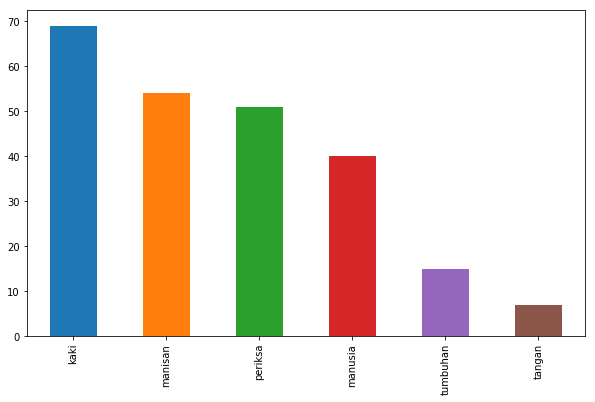

In [11]:
my_tags = ['manisan','manusia','kaki','tangan','periksa','tumbuhan']
plt.figure(figsize=(10,6))
df.CATEGORY.value_counts().plot(kind='bar');

In [12]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['SENTENCE'] = df['SENTENCE'].apply(clean_text)

In [13]:
df['SENTENCE'].apply(lambda x: len(x.split(' '))).sum()

4659

In [14]:
X = df.SENTENCE
y = df.CATEGORY
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 0 ns
accuracy 0.7605633802816901
             precision    recall  f1-score   support

    manisan       0.67      1.00      0.80        22
    manusia       0.71      0.92      0.80        13
       kaki       1.00      0.64      0.78        11
     tangan       0.93      0.81      0.87        16
    periksa       0.00      0.00      0.00         1
   tumbuhan       0.00      0.00      0.00         8

avg / total       0.70      0.76      0.71        71



C:\Users\ifa\Anaconda3\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 0 ns
accuracy 0.8591549295774648
             precision    recall  f1-score   support

    manisan       0.95      0.95      0.95        22
    manusia       0.80      0.92      0.86        13
       kaki       1.00      0.82      0.90        11
     tangan       0.75      0.94      0.83        16
    periksa       0.50      1.00      0.67         1
   tumbuhan       1.00      0.38      0.55         8

avg / total       0.89      0.86      0.85        71



In [17]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Wall time: 0 ns
accuracy 0.8591549295774648
             precision    recall  f1-score   support

    manisan       0.95      0.95      0.95        22
    manusia       0.86      0.92      0.89        13
       kaki       0.90      0.82      0.86        11
     tangan       0.75      0.94      0.83        16
    periksa       0.50      1.00      0.67         1
   tumbuhan       1.00      0.38      0.55         8

avg / total       0.88      0.86      0.85        71



In [23]:
X = df.SENTENCE
y = df.CATEGORY
train_posts, test_posts, train_tags, test_tags = train_test_split(X, y, test_size=0.3, random_state = 42)

#train_size = int(len(df) * .7)
#train_posts = df['SENTENCE'][:train_size]
#train_tags = df['CATEGORY'][:train_size]

#test_posts = df['SENTENCE'][train_size:]
#test_tags = df['CATEGORY'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 20

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 148 samples, validate on 17 samples
Epoch 1/20
148/148 [==============================] - 1s 7ms/step - loss: 1.7868 - acc: 0.2027 - val_loss: 1.6371 - val_acc: 0.5294
Epoch 2/20
148/148 [==============================] - 0s 708us/step - loss: 1.4958 - acc: 0.6284 - val_loss: 1.4621 - val_acc: 0.7647
Epoch 3/20
148/148 [==============================] - 0s 754us/step - loss: 1.2240 - acc: 0.8784 - val_loss: 1.3054 - val_acc: 0.8235
Epoch 4/20
148/148 [==============================] - 0s 752us/step - loss: 1.0193 - acc: 0.9189 - val_loss: 1.1609 - val_acc: 0.8235
Epoch 5/20
148/148 [==============================] - 0s 685us/step - loss: 0.8375 - acc: 0.9122 - val_loss: 1.0334 - val_acc: 0.8235
Epoch 6/20
148/148 [==============================] - 0s 748us/step - loss: 0.6709 - acc: 0.9324 - val_loss: 0.9110 - val_acc: 0.8235
Epoch 7/20
148/148 [==============================] - 0s 713us/step - loss: 0.5406 - acc: 0.9324 - val_loss: 0.8034 - val_acc: 0.8824
Epoch 8/20
148/148 

In [24]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

71/71 [==============================] - 0s 167us/step
Test accuracy: 0.8309859154929577


In [25]:
import pickle
from keras.preprocessing.text import Tokenizer

# creates a HDF5 file 'my_model.h5'
model.model.save('wsd_model21Feb.h5')
 
# Save Tokenizer i.e. Vocabulary
with open('tokenize.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\ifa\Anaconda3\envs\python36\lib\site-packages\keras\engine\sequential.py:110: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


In [26]:
encoder.classes_ #LabelBinarizer

array(['kaki', 'manisan', 'manusia', 'periksa', 'tangan', 'tumbuhan'],
      dtype=object)

In [28]:
labels = encoder.classes_

with open("wsd_test.txt", "r") as ins:
    x_data = []
    for line in ins:
        x_data.append(line)

x_data_series = pd.Series(x_data)
x_tokenized = tokenize.texts_to_matrix(x_data_series, mode='tfidf')

i=0
for x_t in x_tokenized:
    prediction = model.predict(np.array([x_t]))
    predicted_label = labels[np.argmax(prediction[0])]
    print("Sentence ->", x_data_series[i], "Predicted label: " + predicted_label, "\n")
    i += 1

Sentence -> Ramai manusia layak disepak tanpa belas kasihan, tapi tu la nasib perempuan
 Predicted label: kaki 

Sentence -> Dah banyak kali disepak tapi masih tiada keberanian untuk bercerai?
 Predicted label: kaki 

Sentence -> Orang tua tu x minta duit kita x minta harta kita , mereka hanya perlukan kasih sayang dari kita bukan disepak dipukul. Fikir!
 Predicted label: kaki 

Sentence -> Pihak polis bakal mendapatkan perintah tahanan reman bagi membantu siasatan kes memukul seorang anggota polis trafik dan menyepak dua orang awam.
 Predicted label: kaki 

Sentence -> Datuk Farid Kamil ditahan ketika berada di kaunter Polis Trafik Kota Damansara 1.20 petang tadi kerana menampar anggota polis & menyepak orang awam.
 Predicted label: kaki 

Sentence -> #AhedTamimi 16thn ditangkap krn menampar & menyepak serdadu penjajah Zionis Israel yg hendak naik ke rumahnya spy bisa tembaki anak2 & remaja kampung yg lempari serdadu dg batu. Predicted label: kaki 

